In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tqdm.notebook as tqdm
from scipy.interpolate import make_interp_spline

In [ ]:
# synthetic test on heteroscedastic data

# Author: Ruhui Jin

# parameters setting
k = 5
d = 20
F = np.random.normal(0,1,(d,k))
F, R = np.linalg.qr(F)
# signal
lbd_choice = np.exp([0,8])
choice_idx = 0
lbd = lbd_choice[choice_idx]*(1+np.random.rand(k))
F = F@np.diag(lbd)

nb = 4
bsz = 200
n = np.ones(nb)
# noise
noisevar = np.zeros(nb)
noisevar = np.exp(np.linspace(-2,nb,num=nb))
snr = lbd_choice[choice_idx]/noisevar
print(noisevar)
print(lbd)
print(snr)

[ 0.13533528  1.          7.3890561  54.59815003]
[1.99819778 1.52863072 1.17294544 1.94140253 1.862831  ]
[7.3890561  1.         0.13533528 0.01831564]


In [3]:
# clean data and noise generation
Z = np.random.normal(0,1,size=(k,nb*bsz))
E = np.zeros((d,nb*bsz))
for i in range(nb):
  E[:,i*bsz:(i+1)*bsz] = np.random.normal(0,noisevar[i],size=(d,bsz))

data_clean = F@Z
data_noisy = data_clean+E

In [4]:
# OED comparison

## data choices
# 1 clean
# 2 noisy
data_choice = 2

## reweight choices
# 1 no reweight
# 2 noise reweight
# 3 "optimal" reweight
reweight_choice = 3

nseeds = 200
nsample = 50
maxits = 100
regular = 10**(-4)
c = 0.5
max_idx_history = np.zeros((maxits,nseeds))
dvalue_max_history = np.zeros((maxits,nseeds))
weights_history = np.zeros((nsample,nseeds))
sample_idx_history = np.zeros((nsample,nseeds))

for seed in range(nseeds):
  np.random.seed(seed)
  weights = np.ones(nsample)/nsample
  sample_idx = np.random.randint(0,nb*bsz,size=nsample)
  if data_choice == 1:
    data_sample = data_clean[:,sample_idx]
  elif data_choice == 2:
    data_sample = data_noisy[:,sample_idx]

  data_sample = data_sample/np.linalg.norm(data_sample,axis=0) # normalize data norms so that the design doesn't just pick on large-norm data

  noisevar_idx = np.ceil((sample_idx+1)/bsz -1)
  noisevar_idx = noisevar_idx.astype(int)
  noisevar_sample = noisevar[noisevar_idx]
  sample_idx_history[:,seed] = sample_idx
  if reweight_choice == 1:
    reweights = np.ones(nsample)
  elif reweight_choice == 2:
    reweights = 1/(1+noisevar_sample)
  elif reweight_choice == 3:
    reweights = 1/(1+noisevar_sample/lbd_choice[1])
    reweights = reweights*(1/noisevar_sample)

  for t in range(maxits):
    reweights_it = weights*reweights
    reweights_it = reweights_it/np.sum(reweights_it)
    M = data_sample@np.diag(reweights_it)@data_sample.T
    M = M+regular*np.eye(d)
    M_inv = np.linalg.inv(M)

    d_values = np.array([reweights[i]*(data_sample[:,i].T@M_inv@data_sample[:,i])/LA.norm(data_sample[:,i],2)**2 for i in range(nsample)])
    max_idx = np.argmax(d_values)
    max_idx_history[t,seed] = sample_idx[max_idx]
    dvalue_max_history[t,seed] = d_values[max_idx]
    alpha = c/np.sqrt(t+5)
    weights = (1-alpha)*weights
    weights[max_idx] = (1+alpha)*weights[max_idx]
    weights = weights/np.sum(weights)

  weights_history[:,seed] = weights

#print(max_idx_history)
#print(dvalue_max_history)

[[265. 144. 168. ... 185.  31. 354.]
 [ 87. 215. 255. ... 207. 260. 117.]
 [ 99. 357.  31. ...  67. 333. 154.]
 ...
 [ 72. 390.  51. ... 299. 305. 374.]
 [151. 178.  88. ...  77.  16. 363.]
 [288.  71. 168. ... 262. 285. 395.]]


Text(0, 0.5, 'd value')

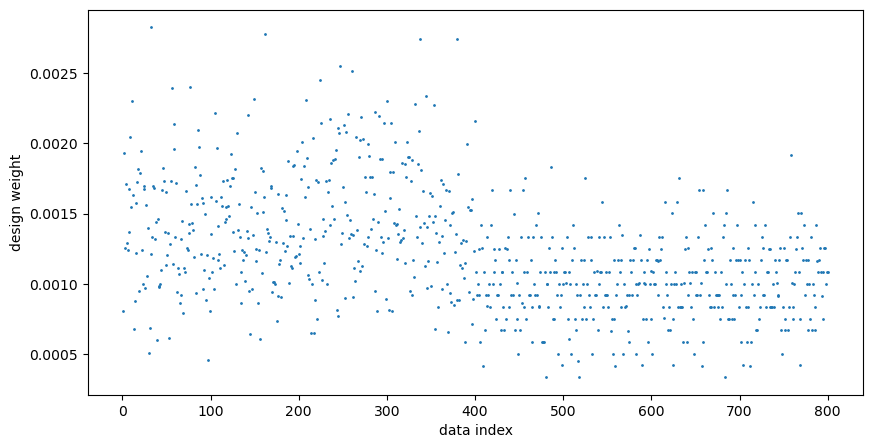

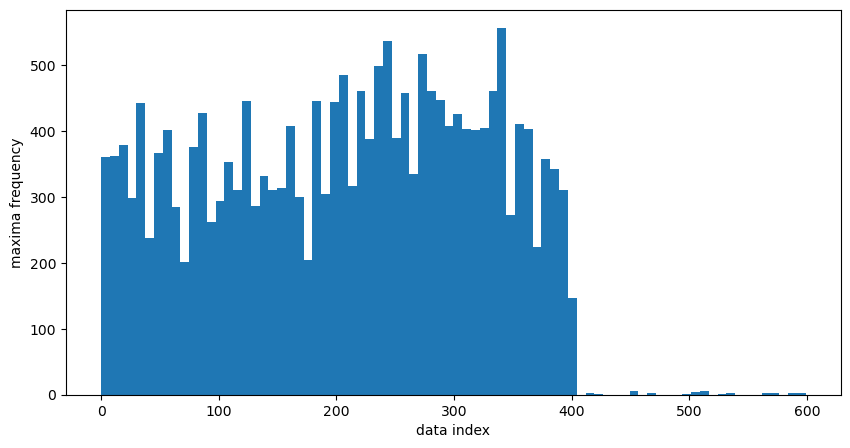

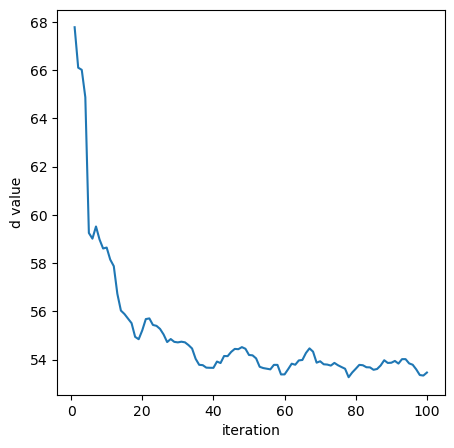

In [5]:
# plots
design = np.zeros(bsz*nb)
for seed in range(nseeds):
  current_design = np.zeros(bsz*nb)
  idx = sample_idx_history[:,seed]
  idx = idx.astype(int)
  current_design[idx] = weights_history[:,seed]
  design = design+current_design

design = design/nseeds

plt.figure(figsize=(10,5))
x = range(1,bsz*nb+1)
y = design
plt.scatter(x,y,s=1)
plt.xlabel('data index')
plt.ylabel('design weight')

plt.figure(figsize=(10,5))
nbins = bsz*nb/10
nbins = int(nbins)
y = np.reshape(max_idx_history,(maxits*nseeds))
plt.hist(y,bins=nbins)
plt.xlabel('data index')
plt.ylabel('maxima frequency')
print(max_idx_history)

plt.figure(figsize=(5,5))
x = range(1,maxits+1)
plt.plot(x,dvalue_max_history[:,1])
plt.xlabel('iteration')
plt.ylabel('d value')